In [49]:
from pathlib import Path
import numpy as np
from scipy.io import loadmat
import pandas as pd
import pickle

In [3]:
path_folder_unprocessed = Path.cwd() / "data" / "input" / "unprocessed"
path_folder_processed = Path.cwd() / "data" / "input" / "processed"

In [4]:
raw = loadmat(path_folder_unprocessed / "KPG193_ver1_2" / "network" / "mat" / "KPG193_ver1_2.mat")["mpc"][0, 0]

In [5]:
num_units = 122
num_buses = 197
fx_rate = 1000
idx_unit_sorted_by_cost_lin = np.argsort(raw["gencost"][:, -2])

---
---
---

**GENERATION UNITS**

In [6]:
# [KPG193] 0: Nuclear, 1: Coal, 2: LNG
unit_type = np.array([
    1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 
    0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
], dtype=np.uint64)[idx_unit_sorted_by_cost_lin]
idx_nuclear = np.arange(num_units)[unit_type == 0]
idx_coal = np.arange(num_units)[unit_type == 1]
idx_lng = np.arange(num_units)[unit_type == 2]

In [7]:
cost_const, cost_lin = (raw["gencost"][:, [-1, -2]] * fx_rate)[idx_unit_sorted_by_cost_lin].transpose()
p_max, p_min = raw["gen"][:, [8, 9]][idx_unit_sorted_by_cost_lin].transpose()
(
    ramp_up,
    ramp_down,
    startup_ramp,
    shutdown_ramp,
    min_up,
    min_down,
) = raw["genthermal"][:, [5, 6, 7, 8, 1, 2]][idx_unit_sorted_by_cost_lin].transpose()
min_up = min_up.astype(np.int64)
min_down = min_down.astype(np.int64)
# [KPG193] error fix
ramp_up[idx_nuclear] = p_min[idx_nuclear]
ramp_down[idx_nuclear] = p_min[idx_nuclear]
startup_ramp[idx_nuclear] = p_min[idx_nuclear]
shutdown_ramp[idx_nuclear] = p_min[idx_nuclear]

In [9]:
for var_str in (
    "unit_type",
    "idx_nuclear",
    "idx_coal",
    "idx_lng",
    "cost_const",
    "cost_lin",
    "p_max",
    "p_min",
    "ramp_up",
    "ramp_down",
    "startup_ramp",
    "shutdown_ramp",
    "min_up",
    "min_down",
):
    np.save(path_folder_processed / f"{var_str}.npy", eval(var_str))

---
---
---

**STARTUP COST**

In [ ]:
startup_costs_raw = (raw["genthermal"][:, -6:-3] * fx_rate)[idx_unit_sorted_by_cost_lin]
tier_len_raw = raw["genthermal"][:, -3:][idx_unit_sorted_by_cost_lin].astype(np.int64)

In [ ]:
cost_startup_step_formulation_1 = [startup_costs_raw[i].tolist() for i in range(num_units)]
step_length_formulation_1 = [tier_len_raw[i].tolist() for i in range(num_units)]

np.save(path_folder_processed / "cost_startup_step_formulation_1.npy", cost_startup_step_formulation_1)
np.save(path_folder_processed / "step_length_formulation_1.npy", step_length_formulation_1)

In [ ]:
cost_startup_step_formulation_0 = []
for idx_unit, (cost_startup_pseudo_i, startup_delay_i) in enumerate(zip(
    startup_costs_raw,
    tier_len_raw
)):
    
    cost_startup_step_formulation_0.append(
            [float(cost_startup_pseudo_i[0])] * startup_delay_i[0]
            + [float(cost_startup_pseudo_i[1])] * (startup_delay_i[1] - startup_delay_i[0])
            + [float(cost_startup_pseudo_i[2])] * (startup_delay_i[2] - startup_delay_i[1])
        )
num_cooling_steps_formulation_0 = np.array([len(css_i) for css_i in cost_startup_step_formulation_0])

with open(path_folder_processed / "cost_startup_step_formulation_0.pkl", "wb") as f:
    pickle.dump(cost_startup_step_formulation_0, f)
np.save(path_folder_processed / "num_cooling_steps_formulation_0.npy", num_cooling_steps_formulation_0)

---
---
---

**2022 HOURLY TIMESTAMP**

In [19]:
timestamp_2022 = np.arange(np.datetime64("2022-01-01T00"), np.datetime64("2023-01-01T00"))
np.save(path_folder_processed / "timestamp_2022.npy", timestamp_2022)

---
---
---

**2022 HOURLY DEMAND** (KPX == KPG)

In [66]:
def get_demand_2022():
    demand_2022 = np.empty((365, 24, num_buses))
    path_folder_per_bus_demand = path_folder_unprocessed / "KPG193_ver1_2" / "profile" / "demand"
    
    for day in range(365):
        demand_2022[day] = (
            pd.read_csv(path_folder_per_bus_demand / f"daily_demand_{day + 1}.csv")
            .drop(columns="demandQ")
            .sort_values(by=["hour", "bus_id"])
            [["demandP"]]
            .values
            .reshape((24, num_buses))
        )

    return demand_2022.reshape((8760, num_buses)).sum(axis=1)

demand_2022 = get_demand_2022()
np.save(path_folder_processed / "demand_2022.npy", demand_2022)

---
---
---

**2022 HOURLY STATUS** (KPG SPECIFIC TO KPG RENEWABLE)

In [71]:
def get_status_2022():
    status_2022 = np.empty((365, 24, num_units), dtype=np.int64)
    path_folder_per_unit_status = path_folder_unprocessed / "KPG193_ver1_2" / "profile" / "commitment_decision"

    for day in range(365):
        status_2022[day] = (
            pd.read_csv(path_folder_per_unit_status / f"commitment_decision_{day + 1}.csv")
            .sort_values(by=["hour", "generator_id"])
            [["status"]]
            .values
            .reshape((24, num_units))
        )

    return status_2022.reshape((8760, num_units)).transpose()[idx_unit_sorted_by_cost_lin]

status_2022 = get_status_2022()
np.save(path_folder_processed / "status_2022.npy", status_2022)

---
---
---

**2022 HOURLY MUST-OFFS** (KPG SPECIFIC TO KPG RENEWABLE)

In [74]:
def get_must_off_2022():
    mustoff_2022 = pd.read_csv(path_folder_unprocessed / "KPG193_ver1_2" / "mustoff" / "nuclear_mustoff.csv").to_numpy()

    # [KPG193] mustoff 'off_end_day' exceeding 365
    mask_exceed_365 = mustoff_2022[:, 3] > 365
    mustoff_2022[:, 3][mask_exceed_365] = 365
    mustoff_2022[:, 4][mask_exceed_365] = 24

    mustoff_2022 -= 1 # 0-based indexing bus and time
    mustoff_2022[:, 1] = mustoff_2022[:, 1] * 24 + mustoff_2022[:, 2]
    mustoff_2022[:, 2] = mustoff_2022[:, 3] * 24 + mustoff_2022[:, 4]

    return mustoff_2022[:, :3] # unit; mustoff_start; mustoff_end

mustoff_2022 = get_must_off_2022()
np.save(path_folder_processed / "mustoff_2022.npy", mustoff_2022)

---
---
---

**2022 HOURLY RENEWABLE** (KPG SPECIFIC)

In [80]:
def get_renewable_ratio_2022():
    solar_ratio_2022, wind_ratio_2022, hydro_ratio_2022 = np.empty((365, 24, num_buses)), np.empty((365, 24, num_buses)), np.empty((365, 24, num_buses))
    path_folder_reg_profile = path_folder_unprocessed / "KPG193_ver1_2" / "profile" / "renewables"
    
    for day in range(365):

        df = (
            pd.read_csv(path_folder_reg_profile / f"renewables_{day + 1}.csv")
            # [KPG193] random CSV nans
            .fillna(0)
            # [KPG193] missing bus 151, duplicate 153 lines for 24 hours
            .assign(bus_id=lambda d: d.bus_id.where(d.bus_id != 152, 151))
            .pipe(lambda d: pd.concat(
                [
                    d[d.bus_id != 153],
                    (
                        d
                        .query("bus_id == 153")
                        .drop_duplicates("hour")
                        .pipe(lambda x: pd.concat([x.assign(bus_id=152),x.assign(bus_id=153)]))
                    )
                ],
                ignore_index=True
            ))
            .sort_values(["hour", "bus_id"])
        )

        solar_ratio_2022[day] = df.pv_profile_ratio.values.reshape(24, num_buses)
        wind_ratio_2022[day] = df.wind_profile_ratio.values.reshape(24, num_buses)
        hydro_ratio_2022[day] = df.hydro_profile_ratio.values.reshape(24, num_buses)

    return solar_ratio_2022.reshape((8760, num_buses)), wind_ratio_2022.reshape((8760, num_buses)), hydro_ratio_2022.reshape((8760, num_buses))


def get_renewable_capacity_2022():
    # [KPG193] 4 missing buses in solar and hydro
    solar_capacity_2022, wind_capacity_2022, hydro_capacity_2022 = np.zeros(num_buses), np.zeros(num_buses), np.zeros(num_buses)
    path_folder_reg_capacity = path_folder_unprocessed / "KPG193_ver1_2" / "renewables_capacity"
    reg_dict = {"solar": solar_capacity_2022, "wind": wind_capacity_2022, "hydro": hydro_capacity_2022}

    for reg_str, reg_var in reg_dict.items():
        raw = (
            pd.read_csv(path_folder_reg_capacity / f"{reg_str}_generators_2022.csv")
            # [KPG193] random CSV nans
            .fillna(0)
            [["bus_ID", "Pmax [MW]"]]
        )
        # [KPG193] 4 missing buses in solar and hydro
        reg_var[raw["bus_ID"].values - 1] = raw["Pmax [MW]"].values 
    
    return solar_capacity_2022, wind_capacity_2022, hydro_capacity_2022


solar_ratio_2022_KPG, wind_ratio_2022_KPG, hydro_ratio_2022_KPG = get_renewable_ratio_2022()
solar_capacity_2022_KPG, wind_capacity_2022_KPG, hydro_capacity_2022_KPG = get_renewable_capacity_2022()
solar_p_2022_KPG, wind_p_2022_KPG, hydro_p_2022_KPG = solar_ratio_2022_KPG * solar_capacity_2022_KPG, wind_ratio_2022_KPG * wind_capacity_2022_KPG, hydro_ratio_2022_KPG * hydro_capacity_2022_KPG

renewable_2022 = (solar_p_2022_KPG + wind_p_2022_KPG + hydro_p_2022_KPG).sum(axis=1)
np.save(path_folder_processed / "renewable_2022.npy", renewable_2022)

---
---
---

In [19]:
df = pd.read_csv(path_folder_unprocessed / "historical_renewable" / "한국전력거래소_신재생 발전량 및 설비용량_20221231.csv", encoding="cp949")

In [20]:
df = df[(df["원료원"] == "태양광") | (df["원료원"] == "풍력") | (df["원료원"] == "수력")]

In [21]:
df = (
    df.groupby(["거래일자", "거래시간"], as_index=False)
      [["설비용량(MW)", "전력거래량(MWh)"]]
      .sum()
)
rec = df["설비용량(MW)"].values
reg = df["전력거래량(MWh)"].values

In [22]:
reg = (reg + reg_kpg) / 2

In [23]:
thermal_demand = demand_2022 - reg_kpg

In [24]:
import matplotlib.pyplot as plt

In [25]:
p_min_true = (status_2022.T * p_min).sum(axis=1)
p_max_true = (status_2022.T * p_max).sum(axis=1)

In [27]:
(p_min_true - thermal_demand > 0).sum()

np.int64(183)

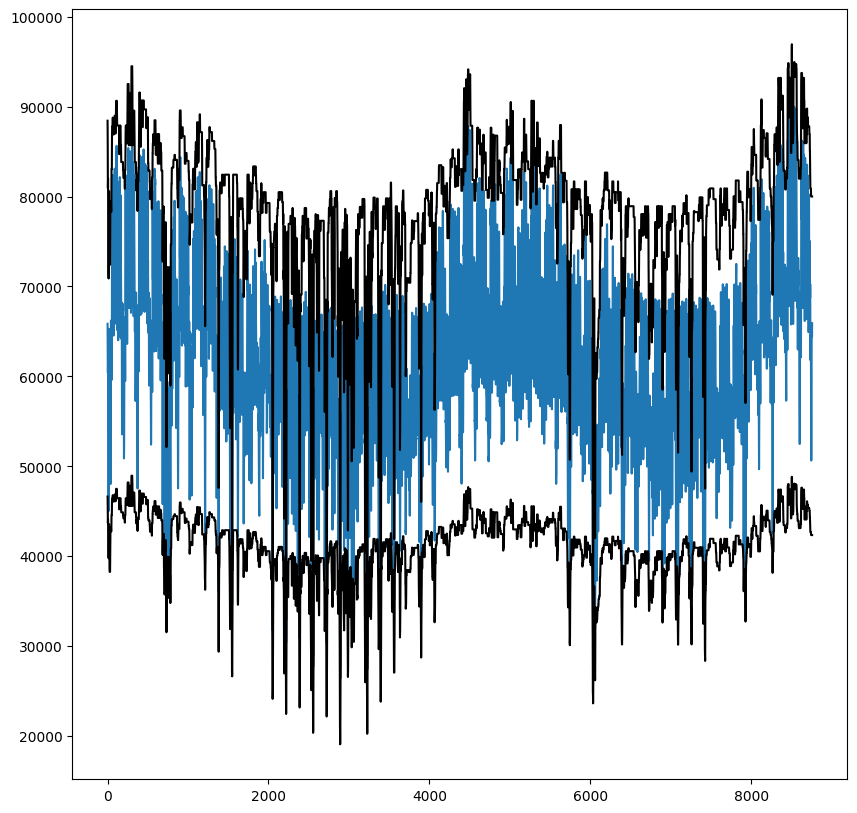

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(demand_2022 - reg)
plt.plot((status_2022.T * p_min).sum(axis=1), c="black")
plt.plot((status_2022.T * p_max).sum(axis=1), c="black")